## __Variational AutoEncoder__

We are going to use variational autoencoder as proposed in the source given below using MNIST dataset. In other notebooks, we will further explore Beta-VAE, VQ_VAE, Dirichlet-VAE, etc.

Source: [Kingma, D.P. and Welling, M., 2019. An introduction to variational autoencoders. _Foundations and Trends® in Machine Learning_, 12(4), pp.307-392.](https://www.nowpublishers.com/article/DownloadSummary/MAL-056)

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchinfo import summary

__MNIST__ dataset is of handwritten digits.

Here, ``test`` has $10,000$ images, and ``train`` has $60,000$ images each with $(28, 28, 1)$ shape

In [2]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [3]:
#Creating data loaders

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


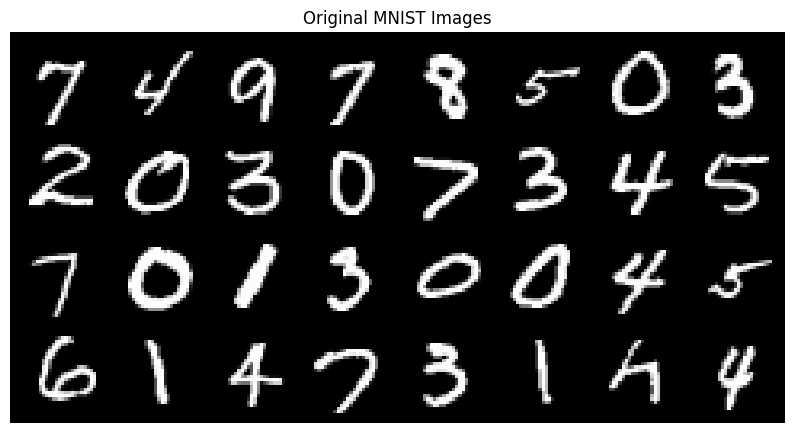

In [4]:
#visualizing some images

def show_images(images, title=None, nrow=8):

  grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0))) #changing order of grid to (H, W, C)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

#getting new batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#plotting images
show_images(images[:32], "Original MNIST Images")

### __Variational Autoencoder (VAE) architecture__

In essence, VAE is a latent variable model. 

Here, given the input $x$, we are trying to approximating latent variable, $z$ that is lower-dimensional continuous vector encoding essential features of input $x$. 
It is further used to reconstruct input data $x$ or new data point $x'$

In VAE, generative model, we learn the joint distribution over the input $x$ and latent variables $z$ as:

$$p_{\theta}(x, z) = p_{\theta}(z) p_{\theta}(x|z)$$

where, $p_{\theta}(z)$ is the prior over the latent space, $p_{\theta}(x|z)$ is the stochastic decoder, and $\theta$ are the parameters. 

Since the true posterior $p_{\theta}(z|x)$ is generally intractable, we introduce a parameterix inference model, called __encoder__ $q_{\theta}(z|x)$ that tries to approximate true posterior as:

$$q_{\phi}(z|x) \approx p_{\theta}(z|x)$$

The encoder uses a neural network to map input data $x$ to the parameters $\mu$ and $\sigma$ of a Guassian distribution from which we sample latent vectors $z$.


__VAE Training :__

The goal of training a VAE is to jointly optimize both the generative model parameter, $\theta$, and the variational parameter $\phi$ so that the aprroximate posterior $q_{\theta}(z|x)$ matches as closely as possible to the true posterior $p_{\theta}(z|x)$ and the model can accurately reconstruct data.

__Evidence Lower Bound (ELBO)__

For any choice of approximate posterior $q_{\theta}(z|x)$, the marginal log-likelihood of the data can be written as:

$$

\text{log}p_{\theta}(x) = \mathbb{E}_{q_{\phi}(z|x)}[\text{log}p_{\theta}(x)]$$


$$= \mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p_{\theta}(x,z)}{p_{\theta}(z|x)}\right] $$

$$\qquad\qquad= \mathbb{E}_{q_{\phi}(z|x)}\left[\log\left[\frac{p_{\theta}(x,z)q_{\theta}(z|x)}{q_{\theta}(z|x)p_{\theta}(z|x)}\right]\right]$$


$$\begin{equation}\qquad\qquad= \mathbb{E}_{q_{\phi}(z|x)}\left[\log \left[\frac{p_{\theta}(x,z)}{q_{\theta}(z|x)}\right]\right] + \mathbb{E}_{q_{\phi}(z|x)} \left[\log\left[\frac{q_{\theta}(z|x)}{p_{\theta}(z|x)}\right]\right] \end{equation}$$


- The second term in $eq(1)$ is the __Kullback-Leibler (KL) Divergence__ between $q_{\theta}(z|x)$ and $p_{\theta}(z|x)$ which is non-negative:

$$D_{KL} (q_{\theta}(z|x) \parallel p_{\theta}(z|x)) \ge 0 \qquad\qquad\qquad\qquad\qquad ...(2)$$

__KL-Divergence__ is zero if and only if, $q_{\theta}(z|x)$ equals the true posterior, $p_{\theta}(z|x)$ 

- The first term in $eq(1)$ is the _variational lower bound_ also called __Evidence Lower Bound (ELBO)__: 

$$ \mathcal{L}_{\theta, \phi}(x) = \mathbb{E}_{q_{\theta}(z|x)}[\log p_{\theta}(x,z) - \log q_{\phi}(z|x)] \qquad\qquad\qquad ...(3)$$

Rearranging from $eq(1), eq(2)$ and $eq(3)$, we get:

$$\mathcal{L}_{\theta, \phi}(x) = \log p_{\theta}(x) -D_{KL} (q_{\theta}(z|x) \parallel p_{\theta}(z|x))$$

$$\le \log p_{\theta}(x)$$

Thus, by maximizing the ELBO, we get a lower bound on the true log-likelihood of the data. So, while training, we optimize the ELBO with respect to both $\theta$ and $\phi$: 

$$\max_{\theta,\phi} \mathcal{L}_{\theta\phi}(x)$$

__Role of KL-Divergence :__

- __Inference Accuracy__ : It quantifies how close the approximated posterior is to true posterior.

- __Bound Tightness__ : It measures the gap between the ELBO and the true log-likelihood, when $q_{\phi}(z|x) = p_{\theta}(z|x)$, we get $D_{KL} (q_{\theta}(z|x) \parallel p_{\theta}(z|x)) = 0$

In [5]:
#Deciding latent dimension for encoder and decoder
latent_dim = 20

In [ ]:
class Encoder(nn.Module):

  def __init__(self, latent_dim = latent_dim):
    super().__init__()
    
    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias =False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )
    self.fc_mean = nn.Linear(128 * 4 * 4, latent_dim)
    self.fc_log_variance = nn.Linear(128 * 4 * 4, latent_dim)

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)  
    mean = self.fc_mean(x)
    log_variance = self.fc_log_variance(x)
    return mean, log_variance

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim=latent_dim):
        super().__init__()
        
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1,output_padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.conv_trans_layers(x)
        return x

#### __Reparameterization Trick__

Approximated posterior $q_{\phi}(z |x)$ is guassian, so it is non-differentiable at the moment. To make it differentiable, we need to decouple randomness by introducing new term $\epsilon$ This is the __re-parameterization trick__ using _mean_ and _log-variance_ given by the neural network of encoder to make latent variable $z$ sampled from $q_{\phi}(z |x)$ differentiable. It can be written as:

$$z = \mu_{\phi}(x) + \sigma_{\phi}(x) ⋅ ϵ $$

In [8]:
def reparameterize(mean, log_variance):
  std = torch.exp(log_variance/2)
  eps = torch.randn_like(std)
  return mean + eps*std

VAE Modelling

In [9]:
class VAE(nn.Module):
  def __init__(self, latent_dim=2):
    super().__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    mean, log_variance = self.encoder(x)
    z = reparameterize(mean, log_variance)
    x_reconstructed = self.decoder(z)
    return x_reconstructed, mean, log_variance

In [10]:
def vae_loss(x_reconstructed, x, mean, log_variance):
  recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction="sum")
  #KL-Divergence
  kld_loss = - 0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
  total_loss = recon_loss + kld_loss
  return recon_loss, kld_loss, total_loss

In [11]:
#hyperparameters to experiment with
learning_rate = 25e-4
num_epochs = 30

model = VAE(latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print(summary(model, input_size=(batch_size,1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 1, 28, 28]          --
├─Encoder: 1-1                           [128, 20]                 --
│    └─Sequential: 2-1                   [128, 128, 4, 4]          --
│    │    └─Conv2d: 3-1                  [128, 32, 14, 14]         288
│    │    └─BatchNorm2d: 3-2             [128, 32, 14, 14]         64
│    │    └─ReLU: 3-3                    [128, 32, 14, 14]         --
│    │    └─Conv2d: 3-4                  [128, 64, 7, 7]           18,432
│    │    └─BatchNorm2d: 3-5             [128, 64, 7, 7]           128
│    │    └─ReLU: 3-6                    [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-7                  [128, 128, 4, 4]          73,728
│    │    └─BatchNorm2d: 3-8             [128, 128, 4, 4]          256
│    │    └─ReLU: 3-9                    [128, 128, 4, 4]          --
│    └─Linear: 2-2                       [128, 20]                 40,980


In [13]:
#training loop
import time
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_kld_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):
    optimizer.zero_grad()
    recon, mean, log_variance = model(data)
    recon_loss, kld_loss, total_loss = vae_loss(recon, data, mean, log_variance)

    total_loss.backward()
    training_loss += total_loss.item()
    accumulated_recon_loss += recon_loss.item()
    accumulated_kld_loss += kld_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.2f} '
          f'Reconstruction Loss: {accumulated_recon_loss /len(train_loader.dataset):.2f} '
          f'KL-Divergence Loss: {accumulated_kld_loss /len(train_loader.dataset):.2f}')
for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch: 1 Total Loss: 141.35 Reconstruction Loss: 117.88 KL-Divergence Loss: 23.47
Epoch: 2 Total Loss: 108.78 Reconstruction Loss: 83.26 KL-Divergence Loss: 25.53
Epoch: 3 Total Loss: 105.95 Reconstruction Loss: 80.30 KL-Divergence Loss: 25.65
Epoch: 4 Total Loss: 104.58 Reconstruction Loss: 78.95 KL-Divergence Loss: 25.62
Epoch: 5 Total Loss: 103.63 Reconstruction Loss: 78.09 KL-Divergence Loss: 25.54
Epoch: 6 Total Loss: 102.85 Reconstruction Loss: 77.36 KL-Divergence Loss: 25.49
Epoch: 7 Total Loss: 102.41 Reconstruction Loss: 77.00 KL-Divergence Loss: 25.41
Epoch: 8 Total Loss: 101.88 Reconstruction Loss: 76.54 KL-Divergence Loss: 25.34
Epoch: 9 Total Loss: 101.50 Reconstruction Loss: 76.23 KL-Divergence Loss: 25.27
Epoch: 10 Total Loss: 101.20 Reconstruction Loss: 75.96 KL-Divergence Loss: 25.24
Epoch: 11 Total Loss: 100.74 Reconstruction Loss: 75.56 KL-Divergence Loss: 25.18
Epoch: 12 Total Loss: 100.54 Reconstruction Loss: 75.39 KL-Divergence Loss: 25.15
Epoch: 13 Total Loss: 10

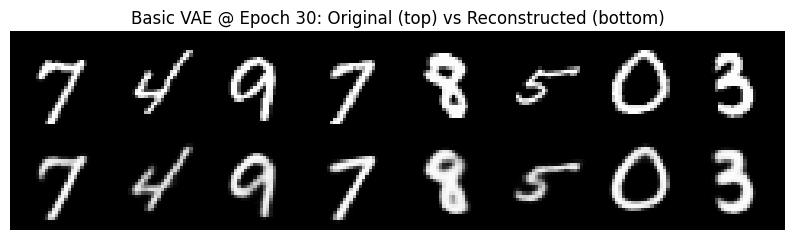

<Figure size 640x480 with 0 Axes>

In [14]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():
  sample = images[:8]
  recon, _, _ = model(sample)

  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Basic VAE @ Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
  plt.savefig('img/basic_vae.png')

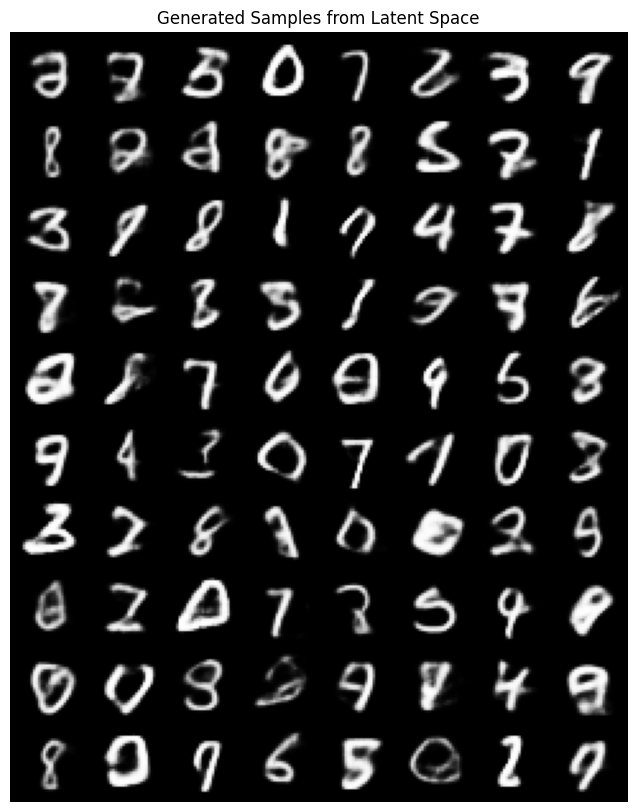

In [15]:
#generating samples from latent space
def generate_samples(model, n=80, nrow=10):
    model.eval()
    with torch.no_grad():
        # Getting the latent dimension from the model's encoder
        latent_dim = model.encoder.fc_mean.out_features
        z = torch.randn(n, latent_dim)
        samples = model.decoder(z)
        show_images(samples, "Generated Samples from Latent Space")

generate_samples(model)

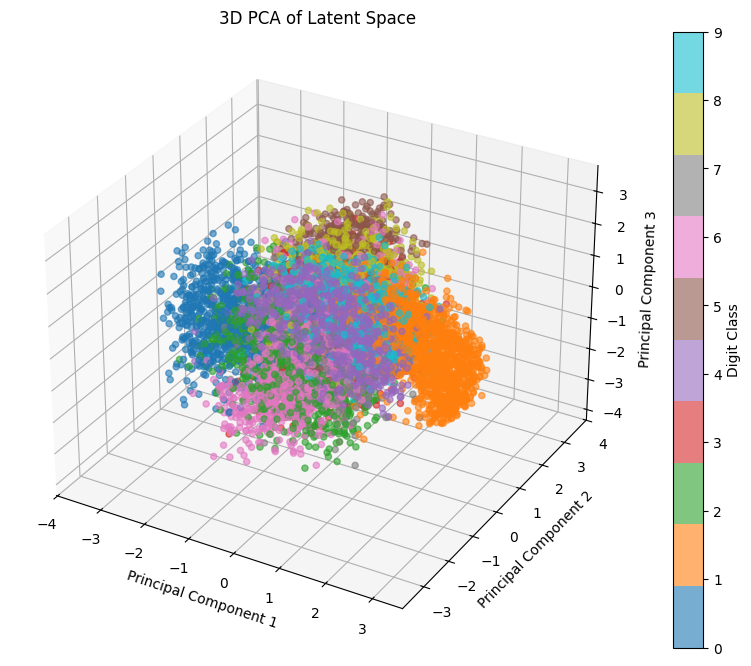

In [16]:
from sklearn.decomposition import PCA

def plot_latent_space_pca(model, data_loader, n_components=3):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            mean, _ = model.encoder(data)
            latents.append(mean)
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Performing PCA to reduce dimensionality to n_components
    pca = PCA(n_components=n_components)
    latents_reduced = pca.fit_transform(latents)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='tab10', alpha=0.6)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of Latent Space')
    fig.colorbar(scatter, ticks=range(10), label='Digit Class')

    plt.show()

plot_latent_space_pca(model, test_loader, n_components=3)

- Variational Autoencoder Experimentation

| Exp No. | Epochs |Latent Dimension | Learning Rate | Total Loss | Reconstruction Loss | KL-D Loss |
| ----| ----- |-----| ---- | -------- | ---- | ----- |
| 1 | 30 | 02 | 1e-3 | 145.51 | 139.26 | 6.25 |
| 2 | 30 | 10 | 1e-3 | 100.56 | 81.06 | 19.50 |
| 3 | 30 | 20 | 1e-3 | 98.26 | 73.35 | 24.91|
| __4__ | __30__ | __20__ | __25e-4__ | __97.72__| __73.21__| __24.51__ |
| 5 | 30 | 10 | 25e-4 |100.98 | 81.75 |19.23 |
| 6 | 50 | 10 | 25e-4 | 99.71 | 80.36 | 19.35 |
| 7 | 50 | 20 | 25e-4 | 96.80 | 72.33 | 24.47 |